<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/rotate_Load_digit_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [285]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import imutils

from sklearn.datasets import load_digits
import sklearn

In [286]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [287]:
dataset = load_digits()

In [288]:
X = dataset.data
y = dataset.target

"""std_scale = sklearn.preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)"""

'std_scale = sklearn.preprocessing.StandardScaler().fit(X)\nX = std_scale.transform(X)'

In [289]:
X1 = X[y == 1]

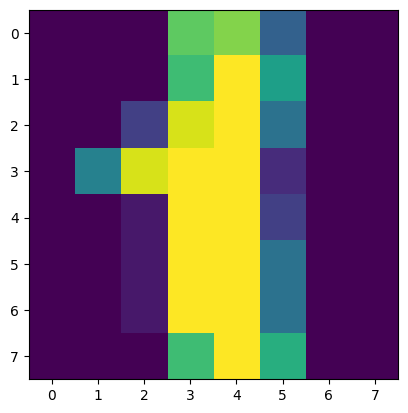

In [290]:
plt.imshow(X1[0].reshape((8,8)))

In [291]:
dim = X1.shape[1]
hidden = 256

model = nn.Sequential(nn.Conv2d(1, 32, 3),
                      nn.Conv2d(32, 64, 3),
                      nn.Flatten(),
                      nn.Linear(dim//2, hidden), nn.ReLU(),
                      nn.Linear(hidden, hidden), nn.ReLU(),
                      nn.Linear(hidden, hidden), nn.ReLU(),
                      nn.Linear(hidden, dim//2))

In [292]:
def coupling_layer(x, m, flow, forward=True):

    x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
    x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

    if forward:
        y_b = x_b - m(x_a)
    else:
        y_b = x_b + m(x_a)

    z = torch.empty(x.shape)
    z[:, ::2] = x_a if flow%2==0 else y_b
    z[:, 1::2] = y_b if flow%2==0 else x_a
    return z

In [293]:
rotated_X1 = np.zeros((X1.shape))
for i in range(len(X1)):
  rot = imutils.rotate(torch.from_numpy(X1[i]).detach().numpy().reshape(8,8), angle=90).reshape((1,64))
  rotated_X1[i] = rot
rotated_X1 = torch.from_numpy(rotated_X1).to(torch.float32)

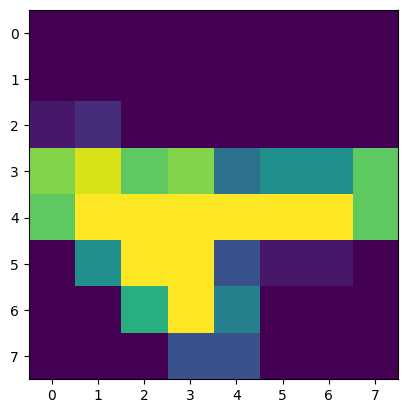

In [294]:
plt.imshow(rotated_X1[5].reshape((8,8)))

In [295]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


n_epochs = 5000
for epoch in range(n_epochs):
  z = coupling_layer(torch.from_numpy(X1).to(torch.float32), model, flow=2, forward=False)
  loss = torch.nn.functional.mse_loss(rotated_X1, z)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch%1000 == 0:
    print("loss :", loss.item())

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [182, 32]

In [ ]:
x_hat = coupling_layer(torch.from_numpy(X[y==1][15].reshape(1,64)).to(torch.float32), model, flow=2, forward=False)
plt.imshow(x_hat.detach().numpy().reshape((8,8)))

In [ ]:
X[y==1][4]

In [ ]:
X1[1]

In [ ]:
plt.imshow(X1[0].reshape((8,8)))